# Titanic Project

## Background & Research Question

This notebook is part of the final project of the Udacity course "Intro to Data Analysis". In this notebook I'll apply the concepts learned in class to visualize the Titanic data and test some hypotheses.

More specifically, the dataset provided lists the information related to 891 passengers of the Titanic, including - but not limited to - how old those passengers were at the time, what was their name or gender, and whether they survived. Here, I'll look at several of those characteristics to identify what factors made people more likely to survive.

**Research question: What factors made people more likely to survive on the Titanic?**

Types of graphs produced: stacked plots, bar plots, histograms, density plots.

In a second part, I'll set up a machine learning algorithm to try to predict the survival of a passenger using the information we have in the database.

Notes: 

Graphs set up using either matplotlib or seaborn. General seaborn tutorial: https://github.com/InsightDataLabs/ipython-notebooks/blob/master/seaborn.ipynb

Regarding Machine Learning, I used the following notebooks for help... thanks a ton to their authors !!
1. 'A Journey through Titanic' https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/ (also used for visualizations)
2. 'Machine Learning for Survival Prediction' https://www.kaggle.com/skywalkerhc/titanic/machine-learning-for-survival-prediction-2
3. 'Kaggle-Titanic-001' https://www.kaggle.com/michielkalkman/titanic/kaggle-titanic-001

## 1. Set-up

In [1]:
# Imports - to run first:
import os
from decimal import *

# pandas
import pandas as pd
from pandas import Series,DataFrame

# unicodecsv
import unicodecsv

# numpy, matplotlib, seaborn
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0 , 5.0) #set default size for graphs
sns.set_style('whitegrid')

import numpy as np

# machine learning
import sklearn
from time import time
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn import datasets, linear_model
from sklearn.naive_bayes import GaussianNB #for Naive Bayes
from sklearn import svm #for SVM
from sklearn.svm import SVC #for SVM with 'rbf' kernel
from sklearn import tree #for decision trees

C:\Users\Flo\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


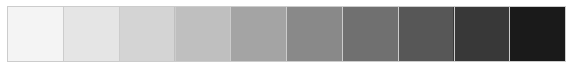

In [2]:
# Choose color palette for the seaborn graphs for the rest of the notebook:
# Import color widget from seaborn:
sns.choose_colorbrewer_palette (data_type='sequential', as_cmap=False)
# Set color palette below:
sns.set_palette("YlGnBu", n_colors=4, desat=None, color_codes=False)

# Matplotlib color codes can be found here: http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

### Read the file and clean the data

In [3]:
titanic_df = pd.read_csv("titanic_data.csv")
# Preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


From this I see that we have 891 rows in total, with 3 fields that are not populated everywhere: Age (714 rows filled), Cabin (only 204 rows) and Embarked (889 rows). Not all fields are in the right format as well ('Sex' for instance is an object), I will take care of this too in the next few steps.

From an overview of the columns and fields available in titanic_df, it looks like the information in some columns is not relevant to our analysis of predicting the survival of a passenger. I would consider those fields to be irrelevant for now:
1. PassengerId
2. Name
3. Ticket
4. Cabin
5. Embarked

I am going to drop those fields in the next step. Then I'll proceed to standardize the remaining data in the dataset before starting the analysis.

In [5]:
# Removing useless fields:
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket','Cabin','Embarked'],axis=1)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.8+ KB


Now let's standardize the data: I will first set a dummy variable for 'Sex', with 0 for male and 1 for female.

In [6]:
# Changing the 'Sex' field from string to integer: 0 for male and 1 for female
titanic_df.loc[titanic_df["Sex"] == "male", "Sex"] = 0
titanic_df.loc[titanic_df["Sex"] == "female", "Sex"] = 1
# Convert to int
titanic_df['Sex'] = titanic_df['Sex'].astype(int)

The biggest question now is what to do with the 'Age' field. 177 rows are not populated; excluding them from the analysis will greatly reduce the size of the dataset and possibly impair the training and testing of the machine learning classifiers. On the other hand, assigning random values to those fields might create a bias in the results. After reading through previous submissions I decided to create a new column, 'Age_filled', and fill the empty rows or N/As there with the median age of the passengers. I'll use this column for the classifiers in part 3., but the data visualization can still be done with the original values.

In [7]:
# Duplicate 'Age' column
titanic_df['Age_filled'] = titanic_df['Age']

# Fill N/As in 'Age_filled' column with median values
titanic_df['Age_filled'] = titanic_df['Age_filled'].fillna(titanic_df['Age'].median())
print "The median age for Titanic passengers is: ", titanic_df['Age'].median()

# Convert from float to int
titanic_df['Age_filled'] = titanic_df['Age_filled'].astype(int)

The median age for Titanic passengers is:  28.0


Continuing with the age of the passengers, I'll create another column, 'Stage', to identify whether I should consider the passengers as Children (if Age <= 15 years old) or Adults (Age > 15). This will help in the 'Age' section of the analysis later on.

In [8]:
# Create new column to identify Children (Age <= 15) vs Adults (Age > 15)
titanic_df['Stage'] = np.where(titanic_df['Age_filled'] <= 15, 0, 1)
titanic_df['Stage'] = titanic_df.Stage.map({0 : 'Child', 1 : 'Adult'})
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age_filled,Stage
0,0,3,0,22.0,1,0,7.2500,22,Adult
1,1,1,1,38.0,1,0,71.2833,38,Adult
2,1,3,1,26.0,0,0,7.9250,26,Adult
3,1,1,1,35.0,1,0,53.1000,35,Adult
4,0,3,0,35.0,0,0,8.0500,35,Adult


Finally, I'll create three more columns, 'Gender', 'Survival' and 'Class', showing the same information as in 'Sex', 'Survived' and 'Pclass' but with more descriptive labels to help with the visualizations later.

In [9]:
# Create Gender Label Column
titanic_df['Gender'] = titanic_df.Sex.map({0 : 'Male', 1 : 'Female'})
titanic_df.Gender.head()

# Create Survival Label Column
titanic_df['Survival'] = titanic_df.Survived.map({0 : 'Died', 1 : 'Survived'})
titanic_df.Survival.head()

# Create Pclass Label Column
titanic_df['Class'] = titanic_df.Pclass.map({1 : 'First Class', 2 : 'Second Class', 3 : 'Third Class'})
titanic_df.Class.head()

titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int32
Age           714 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Age_filled    891 non-null int32
Stage         891 non-null object
Gender        891 non-null object
Survival      891 non-null object
Class         891 non-null object
dtypes: float64(2), int32(2), int64(4), object(4)
memory usage: 76.6+ KB


### Query the Data & Getting used to Panda Dataframes

In [10]:
# Looking for Jack & Rose - because why not:
potential_Jacks = titanic_df[(titanic_df.Sex == 0) & (titanic_df.Pclass == 3) & (titanic_df.Survived == 0) & (titanic_df.Age == 20)].count()
potential_Roses = titanic_df[(titanic_df.Sex == 1) & (titanic_df.Pclass == 1) & (titanic_df.Survived == 1) & (titanic_df.Age == 17)].count()
print "There are %s potential Jacks in our dataset" % (potential_Jacks['Survived'])
print "There are %s potential Roses in our dataset" % (potential_Roses['Survived'])
print "---------"

# Printing out different passengers:
oldest_passenger = titanic_df.loc[titanic_df['Age'].idxmax()]
print "The oldest passenger was %s years old." % oldest_passenger['Age']
youngest_passenger = titanic_df.loc[titanic_df['Age'].idxmin()]
print "The youngest passenger was %s years old." % youngest_passenger['Age']
print "---------"

# Main fares:
print "The cheapest fare cost %s dollars." % titanic_df.loc[titanic_df['Fare'].idxmin()]['Fare']
print "The most expensive one was %s dollars." % titanic_df.loc[titanic_df['Fare'].idxmax()]['Fare']
print "The mean fare was %s dollars." % titanic_df['Fare'].mean()

There are 10 potential Jacks in our dataset
There are 2 potential Roses in our dataset
---------
The oldest passenger was 80.0 years old.
The youngest passenger was 0.42 years old.
---------
The cheapest fare cost 0.0 dollars.
The most expensive one was 512.3292 dollars.
The mean fare was 32.2042079686 dollars.


## 2. Data Analysis and Visualization

I would consider the following fields to be good predictors of survival on the Titanic - Let's investigate those one by one:
1. Gender "Sex" 
2. Class "Pclass"
3. Age 
4. Number of siblings on board "SibSp"
5. Number of children on board "Parch"

### Gender

In [11]:
female_live = titanic_df[(titanic_df.Sex == 1) & (titanic_df.Survived == 1)].count()
male_live = titanic_df[(titanic_df.Sex == 0) & (titanic_df.Survived == 1)].count()
female_all = titanic_df[(titanic_df.Sex == 1)].count()
male_all = titanic_df[(titanic_df.Sex == 0)].count()

print 'Survival rate of female passengers: ', float(female_live['Survived']) / float(female_all['Survived'])
print 'Survival rate of male passengers: ', float(male_live['Survived']) / float(male_all['Survived'])

Survival rate of female passengers:  0.742038216561
Survival rate of male passengers:  0.188908145581


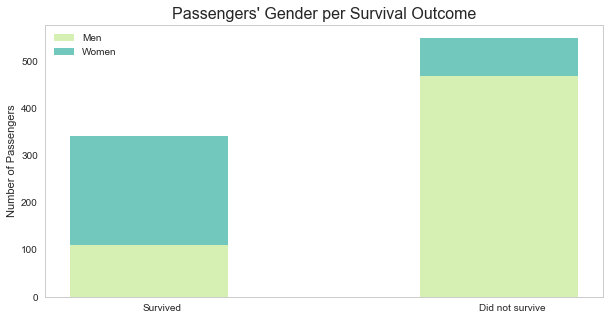

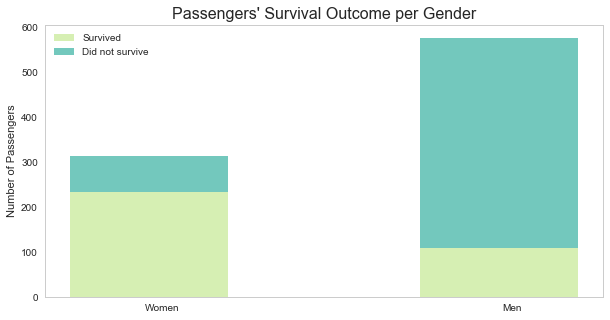

In [12]:
# Original tutorial on http://matplotlib.org/examples/pylab_examples/bar_stacked.html

female_die = female_all['Survived'] - female_live['Survived']
male_die = male_all['Survived'] - male_live['Survived']

# Version 1: show bars as 'Survived' and 'Did not survive'
N = 2
women_data = (female_live['Survived'], female_die)
men_data = (male_live['Survived'], male_die)
ind = np.arange(N)    # the x locations for the groups
width = 0.45       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, men_data, width, align='center')
p2 = plt.bar(ind, women_data, width, bottom=men_data, align='center')

plt.get_cmap('YlGnBu')
plt.ylabel('Number of Passengers')
plt.xticks(ind + width/12., ('Survived', 'Did not survive'))
plt.legend((p1[0], p2[0]), ('Men', 'Women'), loc="upper left")
plt.title("Passengers' Gender per Survival Outcome", fontsize=16)
plt.grid(b=False)
plt.show()

# Version 2: show bars as 'Men' and 'Women'
N = 2
live_data = (female_live['Survived'], male_live['Survived'])
die_data = (female_die, male_die)
ind = np.arange(N)    # the x locations for the groups
width = 0.45       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, live_data, width, align='center')
p2 = plt.bar(ind, die_data, width, bottom=live_data, align='center')

plt.get_cmap('YlGnBu')
plt.ylabel('Number of Passengers')
plt.xticks(ind + width/12., ('Women', 'Men'))
plt.legend((p1[0], p2[0]), ('Survived', 'Did not survive'), loc="upper left")
plt.title("Passengers' Survival Outcome per Gender", fontsize=16)
plt.grid(b=False)
plt.show()

There seem to be a much better survival rate among women than among men (74.2% vs 18.9%). Two possible explanations are: 1) "Women and children first" policy on lifeboats and 2) A higher proportion of women on 1st and 2nd class (which I anticipate have higher survival rates than 3rd class). Let's now investigate the survival rates within classes.

### Passenger Class

First class:  216  Second class:  184  Third class:  491
Total number of passengers (should match to 891):  891


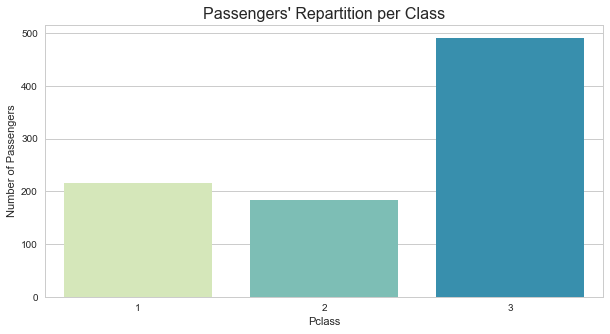

In [13]:
# Divide the Titanic data set into different classes
first_class = titanic_df[(titanic_df.Pclass == 1)].count()
second_class = titanic_df[(titanic_df.Pclass == 2)].count()
third_class = titanic_df[(titanic_df.Pclass == 3)].count()

#Check that all rows in the data set have been allocated to a class set:
print "First class: ", first_class['Survived'], " Second class: ", second_class['Survived'], " Third class: ", third_class['Survived']
print "Total number of passengers (should match to 891): ", first_class['Survived'] + second_class['Survived'] + third_class['Survived']

# Simple bar charts from kaggle notebook https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/
# Version 1: simple count
sns.countplot(x='Pclass', data=titanic_df, order=[1,2,3])
plt.ylabel('Number of Passengers')
plt.title("Passengers' Repartition per Class", fontsize=16)

136.0 of the first class passengers lived, meaning a survival rate of 0.6296
Regarding the second class, 87.0 lived, meaning a survival rate of 0.4728
Finally, 119.0 of the third class passengers lived, meaning a survival rate of 0.2424


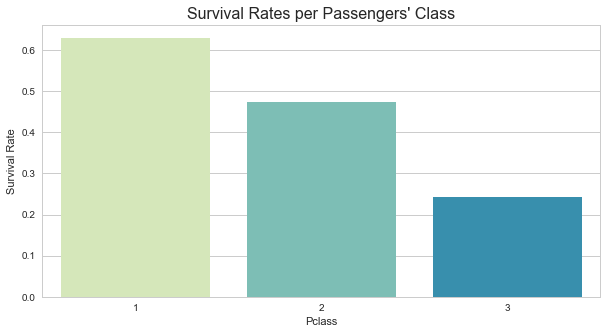

In [14]:
from decimal import *
getcontext().prec = 4

# Print out basic distribution and survival rates accross classes:
first_survived = titanic_df[(titanic_df.Pclass == 1) & (titanic_df.Survived == 1)].count().astype(float)
second_survived = titanic_df[(titanic_df.Pclass == 2) & (titanic_df.Survived == 1)].count().astype(float)
third_survived = titanic_df[(titanic_df.Pclass == 3) & (titanic_df.Survived == 1)].count().astype(float)

ratio_first_survival = Decimal((first_survived['Survived']) / (first_class['Survived']))
ratio_second_survival = Decimal((second_survived['Survived']) / (second_class['Survived']))
ratio_third_survival = Decimal((third_survived['Survived']) / (third_class['Survived']))

# Note: use %s (and not %d) to show decimal places in survival rates
print "%s of the first class passengers lived, meaning a survival rate of %s" % (first_survived['Survived'], round(ratio_first_survival,4))
print "Regarding the second class, %s lived, meaning a survival rate of %s" % (second_survived['Survived'], round(ratio_second_survival,4))
print "Finally, %s of the third class passengers lived, meaning a survival rate of %s" % (third_survived['Survived'], round(ratio_third_survival,4))

# Version 2: with mean
# In dataframe: group by class, and get the mean for survived passengers for each value in Class
pclass_surv_mean = titanic_df[["Pclass", "Survived"]].groupby(['Pclass'],as_index=False).mean()
# Plot the total number of passengers per class
sns.barplot(x="Pclass", y="Survived", data=pclass_surv_mean, label="Total number of passengers", order=[1,2,3])
plt.ylabel('Survival Rate')
plt.title("Survival Rates per Passengers' Class", fontsize=16)

With a survival rate of 63% for the first class passengers compared to the 24% survival rate of the third class, there seems to be a clear disparity of treatment (and chances of survival) between classes. In fact, the only case where passengers were more likely to survive than perish on the Titanic was if they were first class passengers, as shown on the graph below:

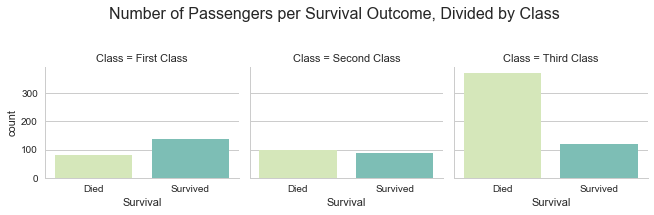

In [15]:
# Original tutorial on http://seaborn.pydata.org/generated/seaborn.factorplot.html#seaborn.factorplot
g = sns.factorplot("Survival", col="Class", col_wrap=3, data=titanic_df, kind="count", size=3, col_order=['First Class','Second Class','Third Class'])
#plt.title("Number of Passengers per Survival Outcome, Divided by Class")
plt.subplots_adjust(top=0.7)
g.fig.suptitle('Number of Passengers per Survival Outcome, Divided by Class', fontsize=16)

Let's look again at those graphs, this time comparing the count of men and women in each class:

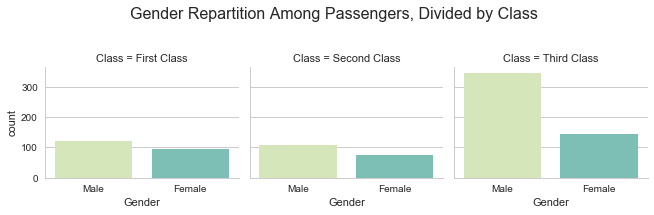

In [16]:
g = sns.factorplot("Gender", col="Class", col_wrap=3, data=titanic_df, kind="count", size=3, col_order=['First Class','Second Class','Third Class'])
plt.subplots_adjust(top=0.7)
g.fig.suptitle('Gender Repartition Among Passengers, Divided by Class', fontsize=16)

As observed above, there was a higher proportion of women in the first and second classes than in the third class. This seems to confirm our hypothesis of earlier and further explain why there is a much better survival rate among women than among men.

### Age

Key metrics:
The average age for Titanic passengers was 29.7 years old; the median is 28.0 and the std is 14.5265.


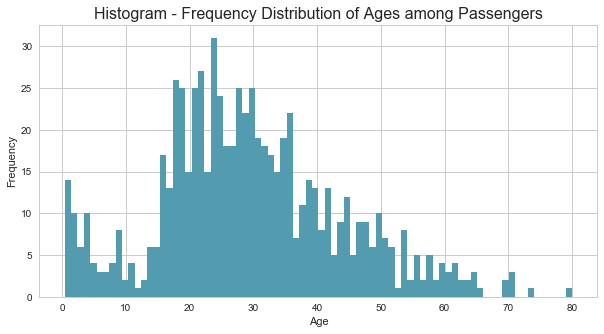

In [17]:
# I'm using the 'Age' column (with NAs) since it is the original data
mean_age = titanic_df['Age'].mean()
median_age = titanic_df['Age'].median()
std_age = titanic_df['Age'].std()
print "Key metrics:"
print "The average age for Titanic passengers was %s years old; the median is %s and the std is %s."% (round(mean_age,2), median_age, round(std_age,4))

# Plot Age values on an histogram
titanic_df['Age'].hist(bins=80, color='#539caf') #bins=80 as ages range from 0 to 80 years old

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.title("Histogram - Frequency Distribution of Ages among Passengers", fontsize=16)
plt.show()

As per the histogram above, it seems that most of the passengers on the Titanic were in between 15 and 35 years old. Let's smooth this distribution further with a density plot:

C:\Users\Flo\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\Flo\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


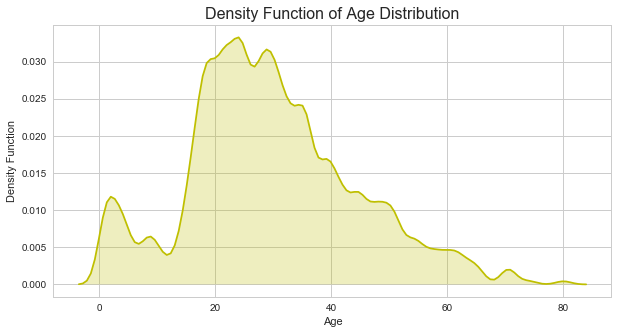

In [18]:
# Density plot. Help on https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib/32803224#32803224
data = titanic_df['Age']
sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw=1.3, color='y', shade=True) # bandwith smoothed to 1.3
plt.ylabel('Density Function')
plt.xlabel('Age')
plt.title("Density Function of Age Distribution", fontsize=16)
# https://en.wikipedia.org/wiki/Kernel_density_estimation#Bandwidth_selection

Let's investigate further using boxplots and violin plots:

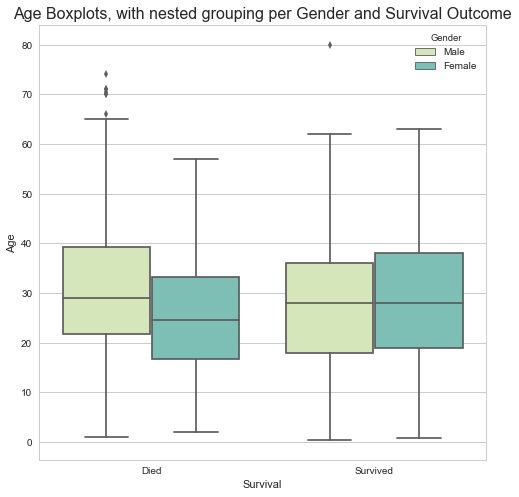

In [19]:
fig, axis1 = plt.subplots(figsize=(8,8))
sns.boxplot(y="Age", x="Survival", hue="Gender", data=titanic_df)
plt.title("Age Boxplots, with nested grouping per Gender and Survival Outcome", fontsize=16)

For a more informative view, let's see the full Age distribution with a violin plot:

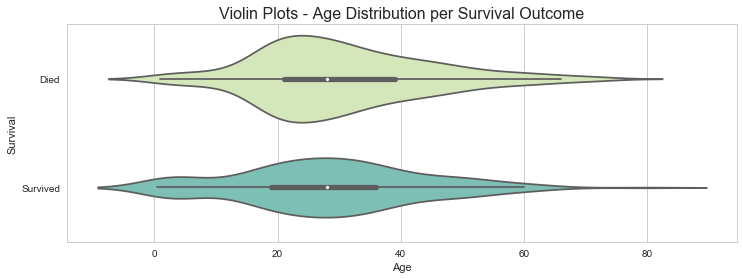

In [20]:
fig, axis1 = plt.subplots(figsize=(12,4))
sns.violinplot(x="Age", y="Survival", data=titanic_df, scale="count")
plt.title("Violin Plots - Age Distribution per Survival Outcome", fontsize=16)

Let's now look at the survival rates per age:

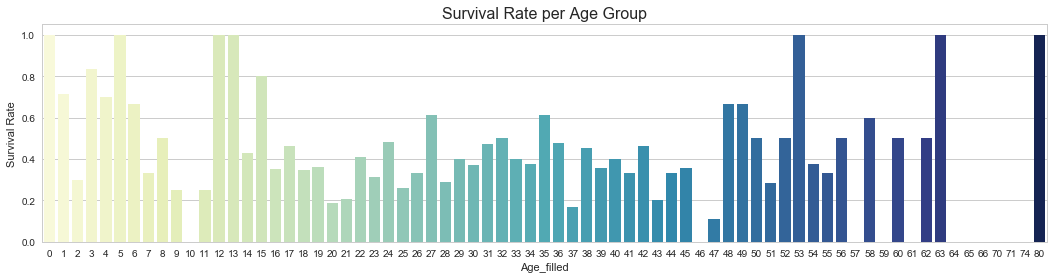

In [21]:
# Inspiration from https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic
# Using Age_filled column to get integers values instead of float
fig, axis1 = plt.subplots(figsize=(18,4))
average_age_survived = titanic_df[["Age_filled", "Survived"]].groupby(['Age_filled'], as_index=False).mean()
sns.barplot(x='Age_filled', y='Survived', data=average_age_survived, palette="YlGnBu")
plt.ylabel('Survival Rate')
plt.title("Survival Rate per Age Group", fontsize=16)

From the histogram above, it looks like a higher proportion of passengers were saved if they were at both ends of the Age spectrum - so either children or elderly people. The age group which would be associated with the most physical strength (let's say in between 16 and 45 years old) is paradoxically the one with the lowest survival rate. Again this seems to agree with our previous hypotheses that the main way of survival was the lifeboats, and children (and apparently elderly people) had the priority on those.

Let's use our categorical variable "Stage" defined earlier to investigate Children vs Adults survival:

There were 83.0 children and 808.0 adults on the Titanic.
49.0 children survived (while 34.0 perished); 293.0 adults survived (while 515.0 perished).
Children' survival ratio:  0.59
Adults' survival ratio:  0.36


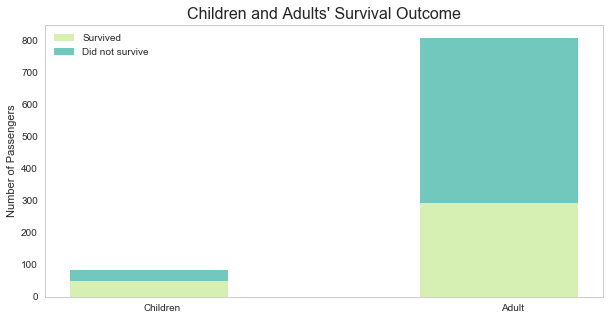

In [22]:
children_live = titanic_df[(titanic_df.Stage == 'Child') & (titanic_df.Survived == 1)].count().astype(float)
adults_live = titanic_df[(titanic_df.Stage == 'Adult') & (titanic_df.Survived == 1)].count().astype(float)
children_all = titanic_df[(titanic_df.Stage == 'Child')].count().astype(float)
adults_all = titanic_df[(titanic_df.Stage == 'Adult')].count().astype(float)
children_die = children_all['Survived'] - children_live['Survived']
adults_die = adults_all['Survived'] - adults_live['Survived']

print "There were %s children and %s adults on the Titanic." % (children_all['Survived'],adults_all['Survived'])
print "%s children survived (while %s perished); %s adults survived (while %s perished)." % (children_live['Survived'], children_die, adults_live['Survived'], adults_die)
print "Children' survival ratio: ", round(Decimal((children_live['Survived']) / (children_all['Survived'])),2)
print "Adults' survival ratio: ", round(Decimal(adults_live['Survived'] / adults_all['Survived']),2)

N = 2
live_data = (children_live['Survived'], adults_live['Survived'])
die_data = (children_die, adults_die)
ind = np.arange(N)    # the x locations for the groups
width = 0.45       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, live_data, width, align='center')
p2 = plt.bar(ind, die_data, width, bottom=live_data, align='center')

plt.get_cmap('YlGnBu')
plt.ylabel('Number of Passengers')
plt.xticks(ind + width/12., ('Children', 'Adult'))
plt.legend((p1[0], p2[0]), ('Survived', 'Did not survive'), loc="upper left")
plt.title("Children and Adults' Survival Outcome", fontsize=16)
plt.grid(b=False)
plt.show()

As suspected, children had a much better chance to survive than adults; close to 60% of passengers aged 15 or below lived, while 36% of the rest of the population onboard perished. Let's now see if that luck extends to families as a whole - extending the "women and children first" theory to the fathers and husbands. 

### Family (Siblings & Children)

The final indicators of survival I will be looking into before moving on to the Machine Learning part are the ones regarding the number of siblings and children of the passengers.

I'll combine the 'SibSp' and 'Parch' datapoints into a 'Family' indicator. The goal here would be to identify if having a family on board made you more or less likely to survive.

In [23]:
# Create a new 'Family' column in the dataframe:
titanic_df['Family'] =  titanic_df['Parch'] + titanic_df['SibSp']

# This column sums up the values in 'Parch' and 'SibSp' columns. 
# I would like to make it a dummy variable, 0 for no family onboard and 1 for one.
titanic_df.loc[titanic_df['Family'] >= 1, 'Family'] = 1
titanic_df.loc[titanic_df['Family'] == 0, 'Family'] = 0
# Convert to int
titanic_df['Family'] = titanic_df['Family'].astype(int)

[<matplotlib.text.Text at 0xe64e828>, <matplotlib.text.Text at 0xe702160>]

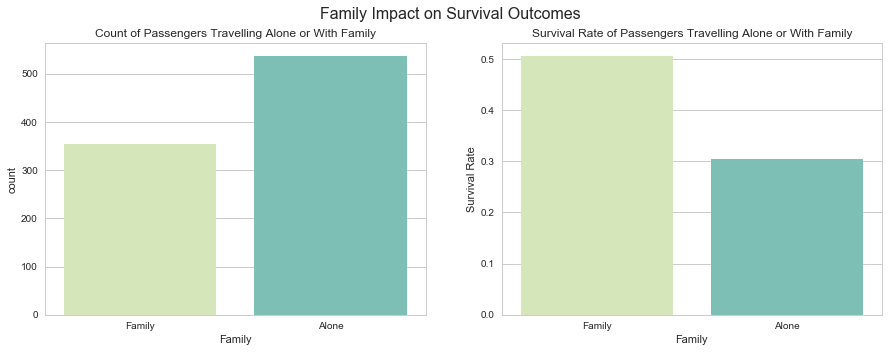

In [24]:
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(15,5))
fig.suptitle("Family Impact on Survival Outcomes", fontsize=16)

# Version 1: simple count
ax1 = sns.countplot(x='Family', data=titanic_df, order=[1,0], ax=axis1)
plt.ylabel('Number of Passengers')
ax1.set_title("Count of Passengers Travelling Alone or With Family")

# Version 2: with mean
# In dataframe: group by class, and get the mean for survived passengers for each value in Class
family_surv_mean = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
# Plot the total number of passengers per class
ax2 = sns.barplot(x="Family", y="Survived", data=family_surv_mean, order=[1,0], ax=axis2)
plt.ylabel('Survival Rate')
ax2.set_title("Survival Rate of Passengers Travelling Alone or With Family")

axis1.set_xticklabels(["Family","Alone"], rotation=0)

From the bar plots above, while a majority of passengers on the Titanic were travelling alone, the ones with a family were more likely to survive. However, this can again be partly linked to the 'Women and children first' rules for the lifeboats, and also to the fact that 3rd class passengers were more likely to be travelling alone, as a proportion of them were employees on the ship. 

Next I decide to isolate the types of passengers less likely to survive - that is, adult men - and see if the adult men with a family onboard were indeed more likely to survive.

In [25]:
# Dividing men above 18 years old into two groups and subgroups: alone / with family, then survived / did not survived:
men_alone = titanic_df[(titanic_df.Gender == 'Male') & (titanic_df['Family'] == 0)].count().astype(float)
men_family = titanic_df[(titanic_df.Gender == 'Male') & (titanic_df['Family'] == 1)].count().astype(float)
men_alone_survived = titanic_df[(titanic_df.Gender == 'Male') & (titanic_df['Family'] == 0) & (titanic_df['Survived'] == 1)].count().astype(float)
men_family_survived = titanic_df[(titanic_df.Gender == 'Male') & (titanic_df['Family'] == 1) & (titanic_df['Survived'] == 1)].count().astype(float)

print "There are %s men alone and %s men with family in our dataset." % (men_alone['Survived'], men_family['Survived'])
print "---------"

# Survival rates in the two groups:
print 'Survival rate of men alone: ', round(Decimal((men_alone_survived['Survived']) / (men_alone['Survived'])),2)
print 'Survival rate of men with family: ', round(Decimal((men_family_survived['Survived']) / (men_family['Survived'])),2)

There are 411.0 men alone and 166.0 men with family in our dataset.
---------
Survival rate of men alone:  0.16
Survival rate of men with family:  0.27


With this check, we see that the survival rate of men was a bit better if they were travelling with a family (27% vs 16%). However, having a family or siblings onboard did not seem to bring them the same luck as with the other types of passengers - women and children.

### Conclusions for the Data Visualization section

As a conclusion, the dataset seems to indicate that the factors more likely to ensure survival on the Titanic were, in order of importance: 

1. Gender (74% of women on the ship survived, versus short of 19% of men).
2. Class (63% of 1st class passengers lived, compared to 47% of 2nd class and 24% of 3rd class passengers).
3. Age (59% of children aged 15 or below lived, compared to 36% of adults).

While this conclusion seems quite coherent with what I was instinctively going for ("women and children first" for the lifeboats, proportionnally more women and children travelling in the 1st or 2nd class than in the 3rd class), I'd like to highligt here the limitations of this analysis and point out some possible improvements.

**Limits of the dataset:**
1. The dataset contains only 891 rows, compared to the 2,300 passengers who were on the Titanic the night of the wreckage.
2. There were quite a lot of missing values in the dataset, particularly in the Age column (177 rows not populated).
3. Other variables which could be of interest are not included in the dataset; for instance, the location of the passengers' cabins on the ship, compared with the location of the iceberg impact.

**Limits of the analysis:**
1. Those visualizations are an indicator of correlation, and not causation; further statistical testing would be required to draw definite conclusions.
2. The 'Fare' variable could maybe be a loose indicator of the location of the cabins on the ship (the most expensive ones could be located on a certain deck, etc), which could be linked to survival.
3. In all plots including Gender, the datapoints do not differentiate between children and adults, which could be diluting our results.

**Potential improvements:**
One other way to look at this dataset and the survival of the passengers is by using Machine Learning classifiers to estimate accuracy of prediction and rank features importance. This is the last section of this noteboook.

## 3. Machine Learning

Now that we got to explore the dataset manually, let's move on to the Machine Learning section. The goal here is to create classifiers to analyze our dataset further and try to predict the survival state of the Titanic passengers using all the other indicators in the dataset.

Ater preparing the dataset and separating the training and testing samples, I'll analyze this dataset with a simple logistic regression model, which will highlight what could be the most important variables for the survival on the Titanic. Then I'll evaluate 3 other different classifiers (Naive Bayes, SVM, and Decision Tree) and compare their respective scores. Finally, I'll regroup what would be the most important features in our dataset according to the best classifier - let's see if it matches with what the regression coefficients suggested !

### Dividing the data into test and train datasets

In [26]:
"""
Dividing the data between training and testing datasets: 
1. Removing 'Survived' from the features (as this is what we are trying to predict)
2. Removing 'Age' column to keep only 'Age_filled', and the other 5 columns we created previously ('Survival', 'Gender', 'Class', 'Stage', 'Family')
3. Keeping 30% of the data points for a test set
""" 
from sklearn.cross_validation import train_test_split

features = titanic_df.drop(["Survived", "Age", "Survival", "Gender", "Class", "Stage", "Family"],axis=1)
labels = titanic_df["Survived"]

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

### Logistic Regression

In [27]:
from sklearn import datasets, linear_model

logreg = linear_model.LogisticRegression()
logreg.fit(features_train, labels_train)

#print('Coefficient:', logreg.coef_)
print('Intercept:', logreg.intercept_)
print('Score on train data:', logreg.score(features_train, labels_train))
print('Score on test data:', logreg.score(features_test, labels_test))

# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])
print coeff_df

('Intercept:', array([ 1.25902923]))
('Score on train data:', 0.7961476725521669)
('Score on test data:', 0.80970149253731338)
      Features  Coefficient Estimate
0       Pclass             -0.806010
1          Sex              2.506118
2          Age             -0.283182
3        SibSp             -0.114789
4        Parch              0.004615
5         Fare             -0.029833
6   Age_filled                   NaN
7        Stage                   NaN
8       Gender                   NaN
9     Survival                   NaN
10       Class                   NaN
11      Family                   NaN


It seems that a simple logistic regression is already doing pretty well at guessing the survival of the passengers in our testing set: we end up with almost 81% accuracy for the test data.

The Coefficient Estimate table, however, is the most interesting here: by comparing the different values for each features, we can easily see that Gender == 1 (female) seems to be the most important variable for survival. Age and Class are the next two in terms of importance; although their coefficients are already much less high. On the other hand, the Parch (number of children) and Fare paid for the cruise have close to zero impact on survival.

### Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

clf = GaussianNB()

t0 = time()
clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t0 = time()
pred = clf.predict(features_test)
print "prediction time:", round(time()-t0, 3), "s"
print "---------"

print "Accuracy score: ", accuracy_score(pred, labels_test)

precision = precision_score(labels_test, pred)
print "Precision: ", precision

recall = recall_score(labels_test, pred)
print "Recall: ", recall

# Calculate F1 score:
f1 = 2 * (precision * recall) / (precision + recall)
print "The F1 score is: ", f1

training time: 0.002 s
prediction time: 0.002 s
---------
Accuracy score:  0.791044776119
Precision:  0.752293577982
Recall:  0.738738738739
The F1 score is:  0.745454545455


As a reminder:
1. Precision = [true positives] / [true positives + false positives] <=> in 75.9% of the cases our model predicted survival of a passenger, it was right.
2. Recall = [true positives] / [true positives + false negatives] <=> our model found 76.5% of the survivors in our dataset.

Those two metrics get almost identical scores here, with around 75% of correct values identified in both situations.
Taking a weighted average of the two, we obtain a F1 score of 0.7623 (the closer to 1 the F1 score gets, the better is our model at predicting survival).


### SVM

In [29]:
from sklearn import svm

clf = svm.SVC(kernel = 'linear')
t0 = time()
clf.fit(features_train, labels_train) 
print "training time:", round(time()-t0, 3), "s"

t0 = time()
pred = clf.predict(features_test)
print "prediction time:", round(time()-t0, 3), "s"
print "---------"

print "Accuracy score: ", accuracy_score(pred, labels_test)

precision = precision_score(labels_test, pred)
print "Precision: ", precision

recall = recall_score(labels_test, pred)
print "Recall: ", recall

# Calculate F1 score:
f1 = 2 * (precision * recall) / (precision + recall)
print "The F1 score is: ", f1

training time: 15.349 s
prediction time: 0.002 s
---------
Accuracy score:  0.791044776119
Precision:  0.772277227723
Recall:  0.702702702703
The F1 score is:  0.735849056604


This third classifier is by far the longest to train (11 seconds). Accuracy and F1 scores are more or less aligned with the NB's ones, only slightly lower.

### Decision Tree

In [30]:
# Setting min_samples_split=40

from sklearn import tree

clf = tree.DecisionTreeClassifier(min_samples_split=40)

t0 = time()
clf = clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"

t0 = time()
pred = clf.predict(features_test)
print "prediction time:", round(time()-t0, 3), "s"
print "---------"

print "Accuracy score: ", accuracy_score(pred, labels_test)

precision = precision_score(labels_test, pred)
print "Precision: ", precision

recall = recall_score(labels_test, pred)
print "Recall: ", recall

# Calculate F1 score:
f1 = 2 * (precision * recall) / (precision + recall)
print "The F1 score is: ", f1

training time: 0.002 s
prediction time: 0.001 s
---------
Accuracy score:  0.794776119403
Precision:  0.85
Recall:  0.612612612613
The F1 score is:  0.712041884817


Similar observations for the Decision Tree classifier: very quick to train, accuracy almost reaching 80%, and F1 score just above 0.7.

Let's have a look at the features importance of this classifier:

In [31]:
#print clf.feature_importances_
print DataFrame(clf.feature_importances_, columns = ["Imp"], index = features_train.columns).sort(['Imp'], ascending = False)

"""
Longer version - keep for reference:
important_features = []
for x,i in enumerate(clf.feature_importances_):
    if i>0.2:
        important_features.append([str(x),str(i)])
        #print (x,i)
    print important_features
"""

                 Imp
Sex         0.529089
Fare        0.170468
Pclass      0.169358
Age_filled  0.131085
SibSp       0.000000
Parch       0.000000


C:\Users\Flo\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


'\nLonger version - keep for reference:\nimportant_features = []\nfor x,i in enumerate(clf.feature_importances_):\n    if i>0.2:\n        important_features.append([str(x),str(i)])\n        #print (x,i)\n    print important_features\n'

Again, this is aligned with our coefficient estimates from the Logistic Regression section, with Gender being by far the most important feature (weighting for 52% of the decision for predicting survival). Interestingly however, Fare comes second with this model, while with the regression it was barely considered in our output.

### Conclusions for the Machine Learning section

I successfully implemented and trained a few classifiers on this dataset, reaching an accuracy of 80%. The results are aligned with my conclusions from the Visualizations section that Gender was a key determinant for the suvival of a passenger on Titanic. The other features seem to be of lesser but equally distributed importance. 

**Note:**
It can be interesting to note that in the case of Age, it is possible that the low number of children on the cruiseship may not be correctly reflected in our results here - with Age weighting for 13% of the predicition, while we saw in the Visualzations part that the survival rate among passengers below 18 years old was very high.

**Potential Improvements:**
In order to get the accuracy score even higher, one possible improvement would be to fine-tune more the parameters of our classifiers, or even implement other, more elaborated classifiers.

Additionnally, we can think of training those classifiers on a larger dataset - there were over 2,300 passengers on the Titanic, while our dataset only contains information on 891 of them.